In [4]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 59.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 104.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Step 1: Setup Environment and Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random

# For text processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# For machine learning and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)

# For baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# For oversampling to handle class imbalance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# For deep learning model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# For MLflow logging
import mlflow
import mlflow.tensorflow
import tempfile

# Set seed for reproducibility
SEED = 22
np.random.seed(SEED)
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)




[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 2: Data Loading and Exploratory Data Analysis (EDA)

In [7]:
# Load the SMS Spam Collection Dataset
df = pd.read_csv("/kaggle/input/sms-spam-dataset/spam.csv", encoding="latin-1")

df = df[['v1', 'v2']]
df.columns = ['label', 'message']

df['label'] = df['label'].map({'ham': 0, 'spam': 1})


# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("First 5 rows:")
print(df.head())

# Check for missing values and duplicate rows
print("Missing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# Analyze class distribution to identify imbalances
print("Class distribution:")
print(df['label'].value_counts())

Dataset shape: (5572, 2)
First 5 rows:
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
Missing values:
 label      0
message    0
dtype: int64
Duplicate rows: 403
Class distribution:
label
0    4825
1     747
Name: count, dtype: int64


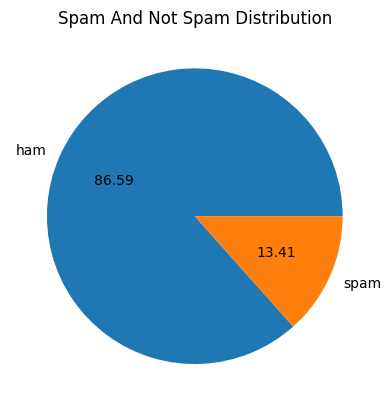

In [8]:
#Spam And Not Spam Distribution
plt.pie(df['label'].value_counts(), labels = ['ham', 'spam'], autopct = "%0.2f")
plt.title("Spam And Not Spam Distribution")
plt.show()

Data is Imbalanced.

In [9]:
#Total number of characters in the message
df['num_characters'] = df['message'].apply(len)
df.head()

,label,message,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [10]:
# num of words
df['num_words'] =df['message'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,label,message,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,23
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [11]:
# num of sentences
df['num_sentences'] =df['message'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,label,message,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [12]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.501256,1.991565
std,59.690841,13.637056,1.501427
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.500000
75%,121.000000,27.000000,2.000000
max,910.000000,219.000000,38.000000


In [13]:
#ham
df[df['label']==0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4825.000000,4825.000000,4825.000000
mean,71.023627,17.076062,1.832332
std,58.016023,13.875446,1.431214
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,92.000000,22.000000,2.000000
max,910.000000,219.000000,38.000000


In [14]:
#spam
df[df['label']==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,747.000000,747.000000,747.000000
mean,138.866131,27.706827,3.020080
std,29.183082,6.768560,1.538034
min,13.000000,2.000000,1.000000
25%,132.500000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,44.000000,9.000000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_characters', ylabel='Count'>

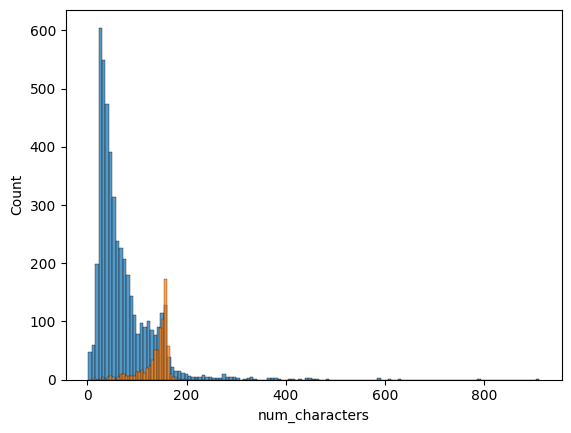

In [16]:
sns.histplot(df[df['label'] == 0]['num_characters'])
sns.histplot(df[df['label'] == 1]['num_characters'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_words', ylabel='Count'>

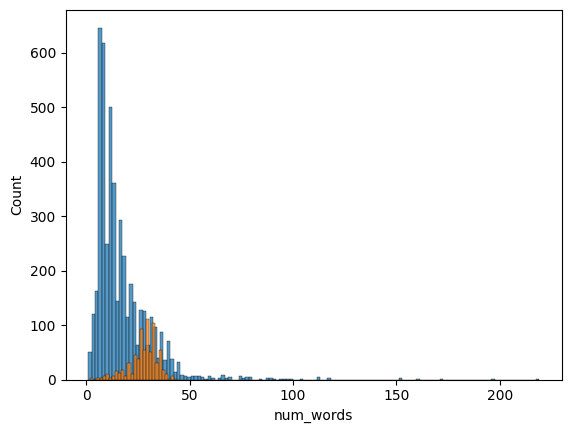

In [17]:
sns.histplot(df[df['label'] == 0]['num_words'])
sns.histplot(df[df['label'] == 1]['num_words'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

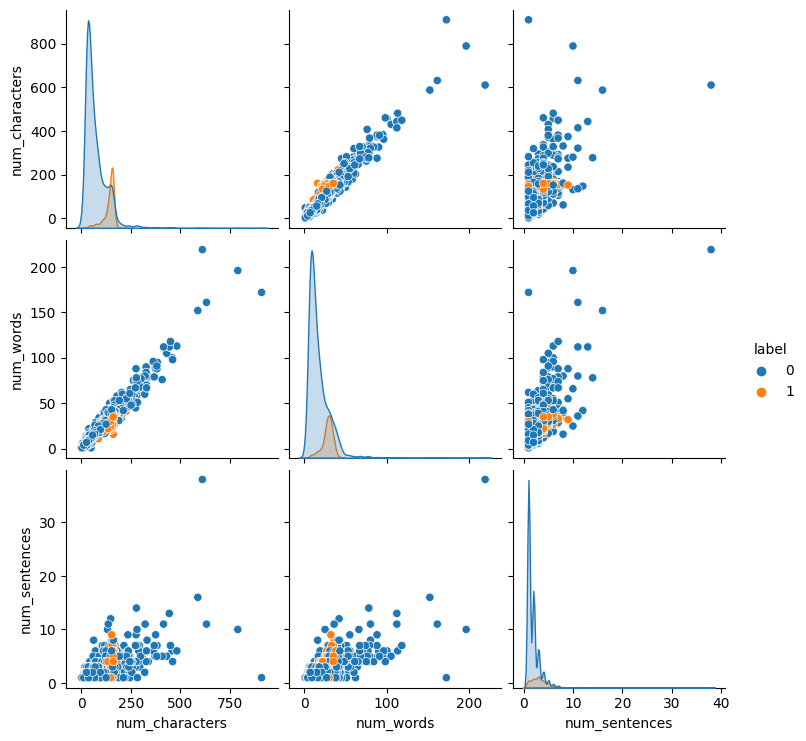

In [19]:
sns.pairplot(df, hue ='label')

<Axes: >

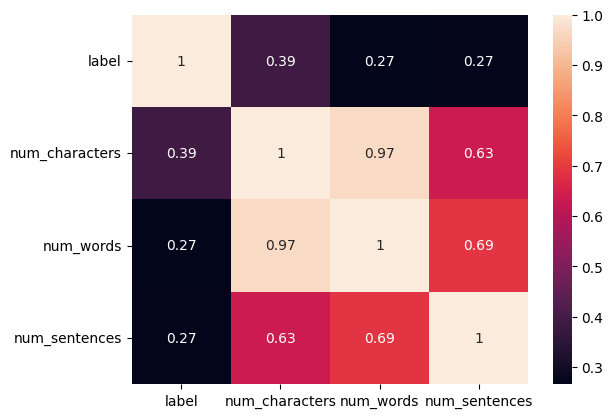

In [22]:
sns.heatmap(df[['label','num_characters','num_words','num_sentences']].corr(), annot =True)

## Step 3: Data Preprocessing and Train-Test Split

In [23]:
# Define a seed for reproducibility
SEED = 42  

def clean_text(text):
    """
    Clean the input text by converting to a string (if not already),
    lowering the case, removing non-alphabetical characters,
    and ensuring messages are not completely removed.
    """
    if not isinstance(text, str):
        text = str(text) if pd.notnull(text) else ""  # Convert non-string values to string
    text = text.lower()
    
    # Allow numbers to prevent complete removal of numeric messages
    text = re.sub(r'[^a-z0-9\s]', '', text)  

    return text.strip() if text.strip() else "empty"  # Replace empty strings with a placeholder

# Apply text cleaning
df['clean_message'] = df['message'].apply(clean_text)

# Split the dataset into training and testing sets (Stratified to maintain label distribution)
X = df['clean_message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Check class distribution before filtering
print("Class distribution before filtering:\n", y_train.value_counts())

# Ensure empty messages are replaced instead of removed
X_train = X_train.apply(lambda x: "empty" if x.strip() == "" else x)

# Reset indices to keep alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Check class distribution after filtering
print("Class distribution after filtering:\n", y_train.value_counts())

# Verify that both classes are still present
if y_train.nunique() == 1:
    print("Error: Only one class remains after filtering. Adjust cleaning logic.")


Class distribution before filtering:
 label
0    3859
1     598
Name: count, dtype: int64
Class distribution after filtering:
 label
0    3859
1     598
Name: count, dtype: int64


## Step 4: Baseline Model using Naive Bayes & Logistic Regression

### Step 4.1: Baseline Model using Naive Bayes

Naive Bayes Performance:
Accuracy: 0.9757847533632287
Precision: 0.9121621621621622
Recall: 0.9060402684563759
F1 Score: 0.9090909090909091
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.91      0.91      0.91       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



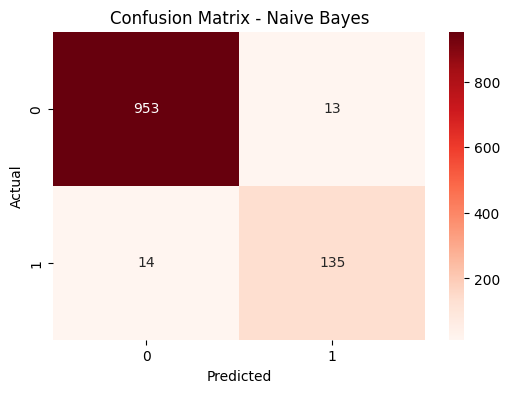

In [24]:
# Convert text to TF-IDF features, fitting on the training set only to avoid data leakage
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)


# Train a naive bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train_bal, y_train_bal)

# Predict on the test set
y_pred_NB = NB_model.predict(X_test_tfidf)

# Evaluate the baseline model with various metrics
print("Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_NB))
print("Precision:", precision_score(y_test, y_pred_NB))
print("Recall:", recall_score(y_test, y_pred_NB))
print("F1 Score:", f1_score(y_test, y_pred_NB))
print("Classification Report:\n", classification_report(y_test, y_pred_NB))

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_NB)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



### Step 4.2: Baseline Model using Logistic Regression

Logistic Regression Performance:
Accuracy: 0.979372197309417
Precision: 0.9315068493150684
Recall: 0.912751677852349
F1 Score: 0.9220338983050848
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.91      0.92       149

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



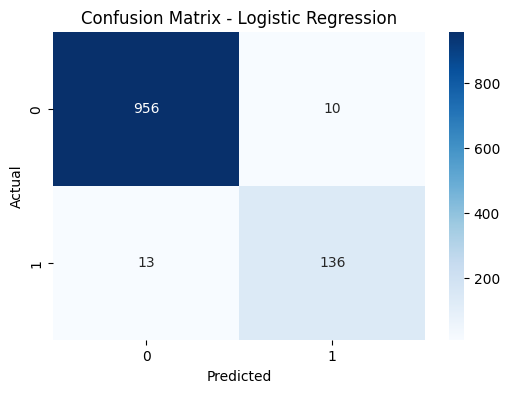

In [25]:
# Train a logistic regression model
log_reg = LogisticRegression(random_state=SEED, max_iter=500)
log_reg.fit(X_train_bal, y_train_bal)

# Predict on the test set
y_pred_lr = log_reg.predict(X_test_tfidf)

# Evaluate the baseline model with various metrics
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Step 5: RNN Model using LSTM

In [26]:
# Set tokenizer parameters
max_words = 5000  # Maximum number of words in the vocabulary
max_len = 100  # Maximum length of input sequences 
embaddung_dim = 16  # Dimension of the word embeddings

# Initialize the tokenizer and fit it on the text data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['message'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['message'])

# Pad sequences to ensure uniform input size
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Define labels and split data into training and testing sets
X = padded_sequences
y = np.array(df['label'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build the LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embaddung_dim),
    Bidirectional(LSTM(64, return_sequences=True)),  
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))

# Display the model architecture
model.summary()

# Train the LSTM model using the training set and class weights to mitigate imbalance
history = model.fit(X_train, y_train,
                    epochs=5, batch_size=32
                    , validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          41,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,745 (639.63 KB)

 Trainable params: 163,745 (639.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.7184 - loss: 0.4847 - val_accuracy: 0.9731 - val_loss: 0.1161
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.9853 - loss: 0.0991 - val_accuracy: 0.9848 - val_loss: 0.0547
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.9851 - loss: 0.0530 - val_accuracy: 0.9865 - val_loss: 0.0597
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.9966 - loss: 0.0257 - val_accuracy: 0.9821 - val_loss: 0.0685
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.9974 - loss: 0.0154 - val_accuracy: 0.9839 - val_loss: 0.0771


## Step 6: Evaluate the LSTM Model

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
LSTM Model Performance:
Accuracy: 0.9838565022421525
Precision: 1.0
Recall: 0.8791946308724832
F1 Score: 0.9357142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.88      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



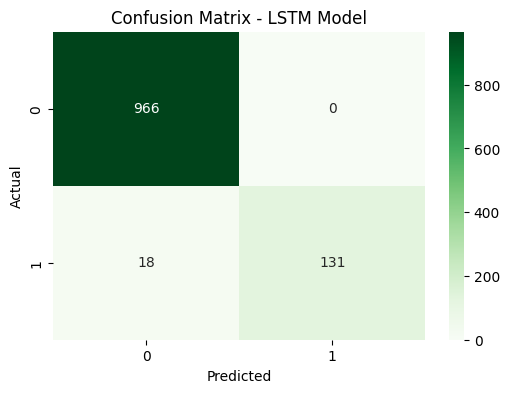

In [27]:
# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate evaluation metrics for the LSTM model
print("LSTM Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot the confusion matrix for the LSTM model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - LSTM Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Step 7: MLflow Logging of Parameters, Metrics, and Artifacts

In [28]:
# Set up and start an MLflow experiment
mlflow.set_experiment("SMS_Spam_Detection")

with mlflow.start_run(run_name="LSTM_SMS_Classification"):
    # Log model parameters in a structured way
    model_params = {
        "max_words": max_words,
        "max_len": max_len,
        "lstm_units": 64,
        "dense_units": 32,
        "dropout_rate": 0.2,
        "learning_rate": 0.001,
        "batch_size": 32,
        "epochs": len(history.history['loss'])
    }
    mlflow.log_params(model_params)
    
    # Log evaluation metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)

    metrics = {
        "accuracy": test_accuracy,
        "precision": test_precision,
        "recall": test_recall,
        "f1_score": test_f1
    }
    mlflow.log_metrics(metrics)

    # Save and log the confusion matrix as an artifact
    cm_fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
    plt.title("Confusion Matrix - LSTM Model")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # plt.show() 
    # Save the figure to a temporary file and log it
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        cm_fig.savefig(tmpfile.name)
        mlflow.log_artifact(tmpfile.name)

    # Close the figure to free memory
    plt.close(cm_fig)

    # Log the trained model with input example and signature
    input_example = np.expand_dims(X_test[0], axis=0)  # Example input for model inference
    signature = mlflow.models.infer_signature(input_example, model.predict(input_example))

    mlflow.tensorflow.log_model(model, "lstm_model", input_example=input_example, signature=signature)


2025/03/14 11:11:43 INFO mlflow.tracking.fluent: Experiment with name 'SMS_Spam_Detection' does not exist. Creating a new experiment.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


## Step 8: Save the Model and Pipeline for Deployment

In [29]:
# Save the trained LSTM model to a file
model_save_path = "lstm_sms_spam_model.h5"
model.save(model_save_path)

# Save the tokenizer to ensure the same preprocessing is applied during inference
import pickle
tokenizer_save_path = "tokenizer.pkl"
with open(tokenizer_save_path, "wb") as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved successfully.")


Model and tokenizer saved successfully.
